In [ ]:
import pandas as pd
import numpy as np

# --- 1. Load Datasets ---
# Assuming both files are uploaded to the Colab environment.
try:
    df_nas = pd.read_csv("cleaned_dataset_NAS.csv")
    df_crime = pd.read_csv("districtwise-sll-crimes-2017-onwards.csv")
    print("Datasets loaded successfully.\n")
except FileNotFoundError:
    print("Error: Ensure both 'cleaned_dataset_NAS.csv' and 'districtwise-sll-crimes-2017-onwards.csv' are uploaded to your Colab session.")
    exit()

# --- 2. Data Cleaning and Standardization for Merging ---

# Standardize column names in crime dataset for merging
df_crime = df_crime.rename(columns={
    'state_name': 'State',
    'district_name': 'District',
    'year': 'Year'
})

# Standardize district names by converting to lowercase/uppercase (simple cleaning)
df_nas['State'] = df_nas['State'].str.upper().str.strip()
df_nas['District'] = df_nas['District'].str.upper().str.strip()
df_crime['State'] = df_crime['State'].str.upper().str.strip()
df_crime['District'] = df_crime['District'].str.upper().str.strip()

# --- 3. Total Crime Aggregation ---

# Identify all crime-related columns (all float64 columns except the first few keys)
crime_cols_to_sum = df_crime.select_dtypes(include=[np.float64]).columns.tolist()

# The first float columns are usually 'dowry_prohibition' onwards, let's confirm the slice
# crime_cols_to_sum starts from 'dowry_prohibition' (index 7 in df_crime.info() output)
df_crime['Total_Crime'] = df_crime[crime_cols_to_sum].sum(axis=1)

# Select only the necessary columns from the crime data for merging
crime_subset = df_crime[['State', 'District', 'Year', 'Total_Crime',
                         'protection_of_children_from_sexual_offences',
                         'women_protection_from_domestic_voilence']].copy()

# --- 4. Merge the DataFrames ---

# Merge on the common keys: State, District, Year
df_merged = pd.merge(df_nas, crime_subset, on=['State', 'District', 'Year'], how='inner')

print(f"Merged Data Shape: {df_merged.shape[0]} rows. Data successfully merged on State, District, and Year.\n")

# --- 5. Correlation Analysis (Socio-Educational Correlation) ---

# Define key columns for correlation
education_cols = ['Overall_Performance', 'Language_Performance', 'Math_Performance', 'SST_Performance']
crime_cols = ['Total_Crime', 'protection_of_children_from_sexual_offences', 'women_protection_from_domestic_voilence']

# Calculate correlation matrix
correlation_matrix = df_merged[education_cols + crime_cols].corr()

print("--- Correlation between Educational Performance and Crime Insights ---")
print("A negative correlation (close to -1) suggests that higher performance is associated with lower crime.")
print(correlation_matrix.loc[education_cols, crime_cols].round(3))

print("\n" + "="*80 + "\n")

# --- 6. Regional Benchmarking (Outlier Insights) ---

# Sort by Overall_Performance (highest is best)
top_performance = df_merged.sort_values(by='Overall_Performance', ascending=False)[['State', 'District', 'Year', 'Overall_Performance', 'Total_Crime']].head(5)

# Sort by Total_Crime (lowest is best, but high crime districts are the outliers here)
top_crime = df_merged.sort_values(by='Total_Crime', ascending=False)[['State', 'District', 'Year', 'Overall_Performance', 'Total_Crime']].head(5)

print("--- Top 5 Districts by Overall Educational Performance (Potentially 'Safe' Regions) ---")
print(top_performance.to_markdown(index=False))

print("\n--- Top 5 Districts by Total Recorded Crime (Potentially 'Challenged' Regions) ---")
print(top_crime.to_markdown(index=False))

Datasets loaded successfully.

Merged Data Shape: 1616 rows. Data successfully merged on State, District, and Year.

--- Correlation between Educational Performance and Crime Insights ---
A negative correlation (close to -1) suggests that higher performance is associated with lower crime.
                      Total_Crime  \
Overall_Performance        -0.015   
Language_Performance        0.111   
Math_Performance            0.003   
SST_Performance            -0.041   

                      protection_of_children_from_sexual_offences  \
Overall_Performance                                        -0.097   
Language_Performance                                       -0.001   
Math_Performance                                           -0.094   
SST_Performance                                            -0.091   

                      women_protection_from_domestic_voilence  
Overall_Performance                                     0.012  
Language_Performance                              

Merged Data Shape: 1616 rows. Data successfully merged on State, District, and Year.

--- Correlation between Educational Performance and Child-related Crime ---
A negative correlation suggests that higher performance is associated with lower child-related crime.
                     Total_Child_Crimes
Overall_Performance              -0.076
SST_Performance                  -0.068




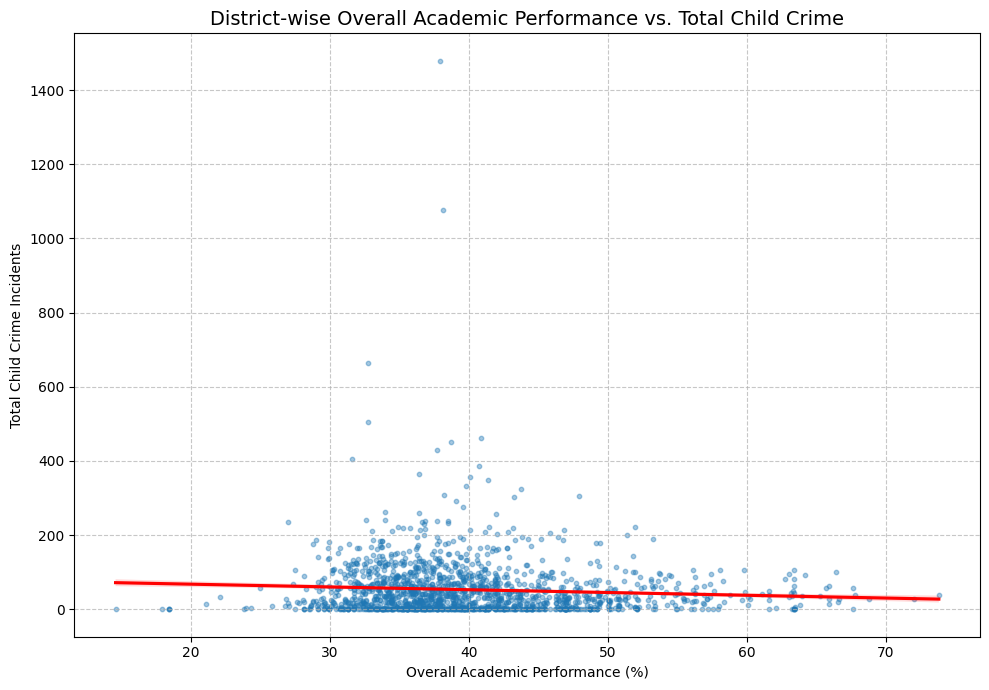

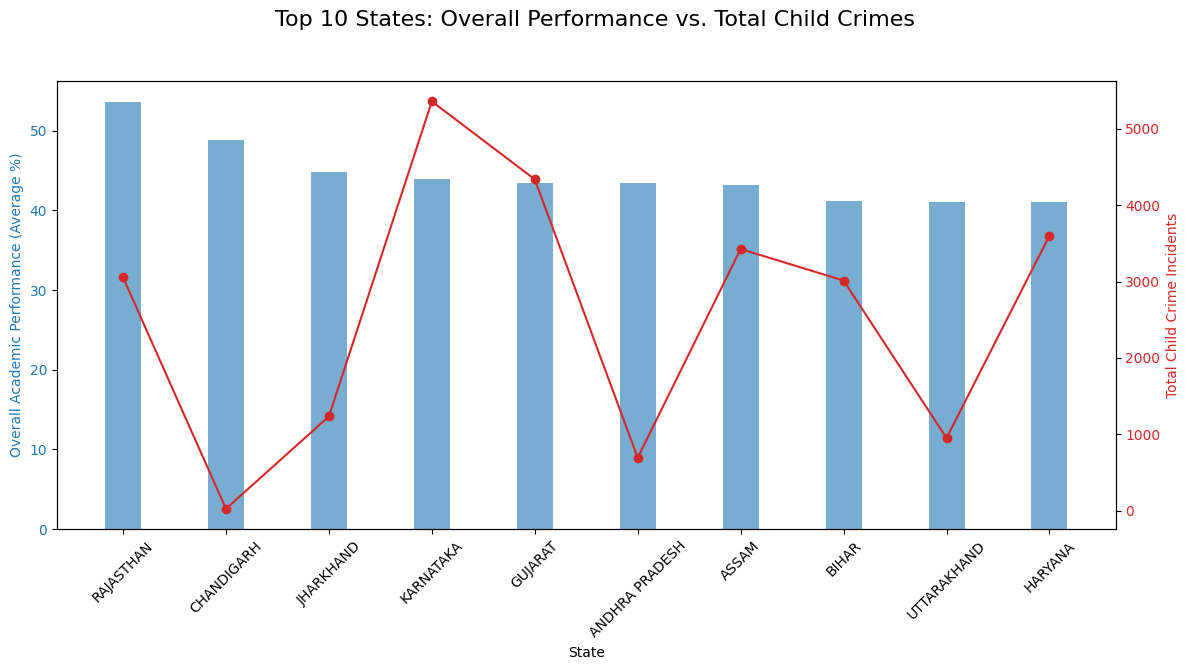

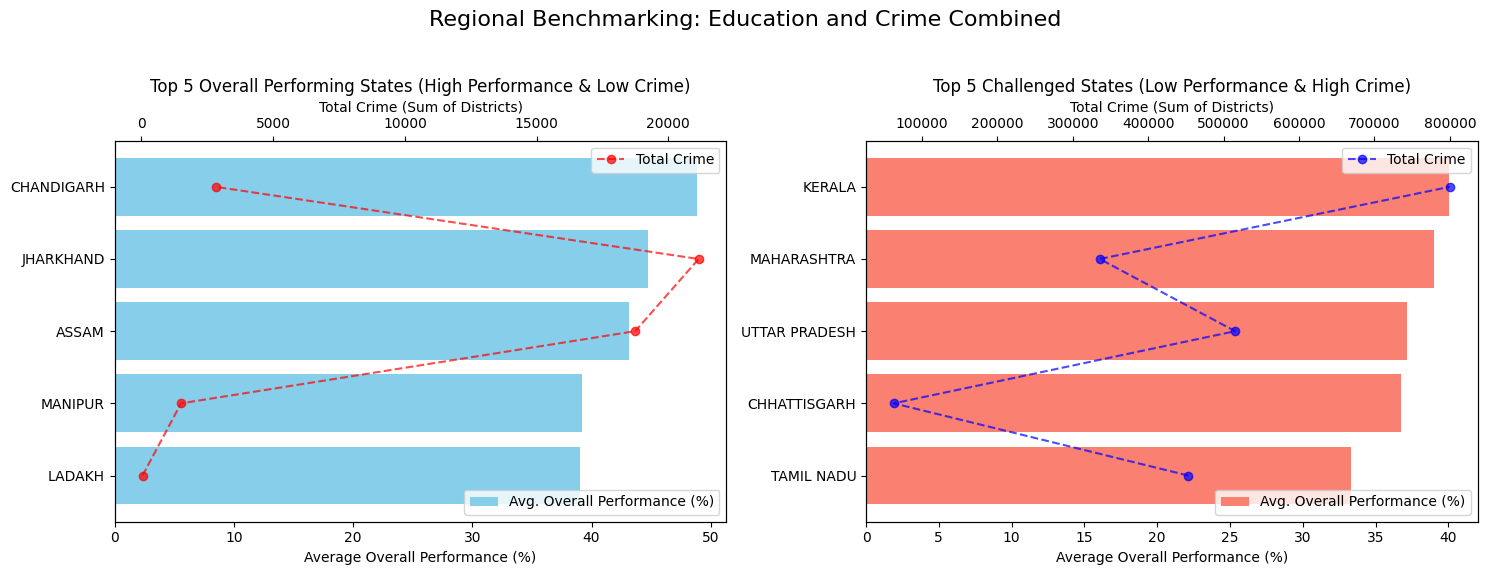

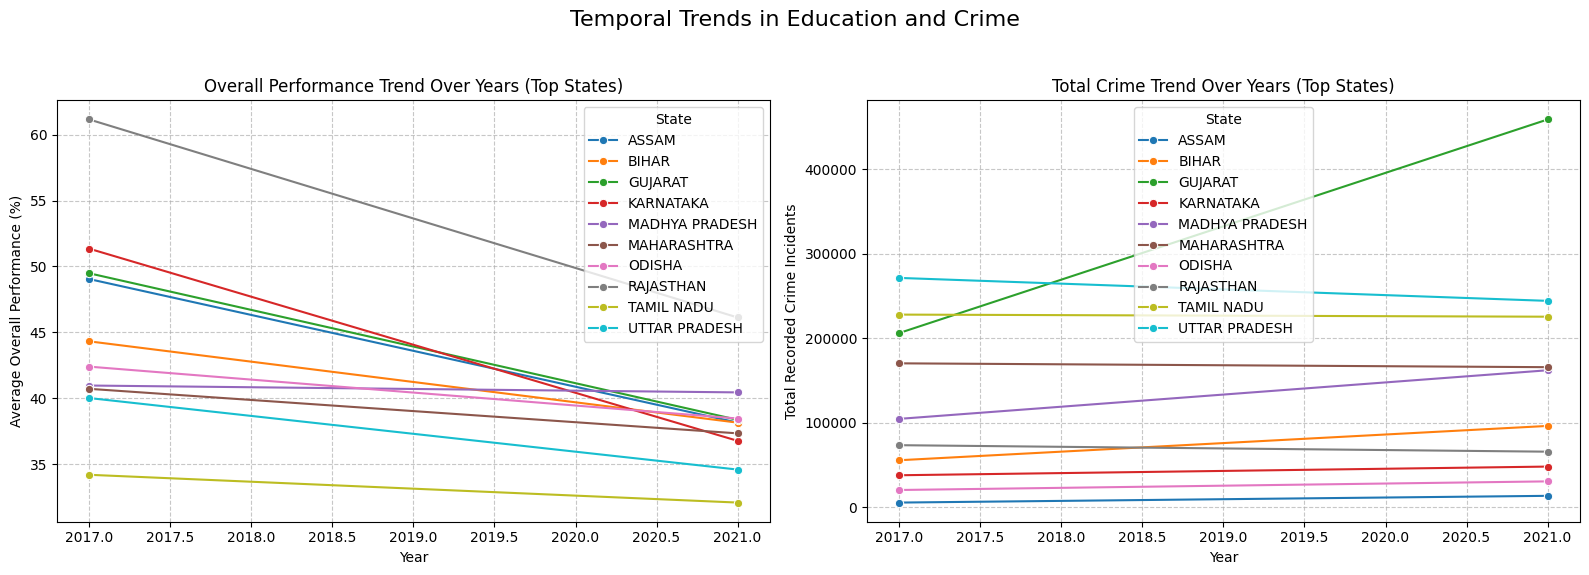

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Loading and Preparation ---

# Load datasets
df_nas = pd.read_csv("cleaned_dataset_NAS.csv")
df_crime = pd.read_csv("districtwise-sll-crimes-2017-onwards.csv")

# Standardize column names and values for merging
df_crime = df_crime.rename(columns={
    'state_name': 'State',
    'district_name': 'District',
    'year': 'Year'
})

# Standardize case and strip whitespace
for df in [df_nas, df_crime]:
    df['State'] = df['State'].astype(str).str.upper().str.strip()
    df['District'] = df['District'].astype(str).str.upper().str.strip()

# Calculate Total Crime and specific crime metrics
crime_cols_to_sum = df_crime.select_dtypes(include=[np.float64]).columns.tolist()
df_crime['Total_Crime'] = df_crime[crime_cols_to_sum].sum(axis=1)

# Child and Juvenile Welfare Analysis Metrics
child_crime_cols = [
    'protection_of_children_from_sexual_offences',
    'juvenile_justice_care_and_protection_of_children',
    'prohibition_of_child_marriage',
    'child_labour_prohibition_regulation'
]
df_crime['Total_Child_Crimes'] = df_crime[child_crime_cols].sum(axis=1)

# Social Crimes Metrics (kept for consistency, but not used in current request's plots/correlation)
social_crime_cols = [
    'prevention_of_atrocities_against_scs',
    'women_protection_from_domestic_voilence',
    'protection_of_civil_rights_against_scs'
]
df_crime['Total_Social_Crimes'] = df_crime[social_crime_cols].sum(axis=1)


# Select necessary columns from crime data
crime_subset = df_crime[['State', 'District', 'Year', 'Total_Crime', 'Total_Child_Crimes', 'Total_Social_Crimes']].copy()

# Merge the DataFrames
df_merged = pd.merge(df_nas, crime_subset, on=['State', 'District', 'Year'], how='inner')

print(f"Merged Data Shape: {df_merged.shape[0]} rows. Data successfully merged on State, District, and Year.\n")

# --- New: Correlation Analysis (Child-related Crime) ---

# Define key columns for correlation based on user request
education_cols_for_child_corr = ['Overall_Performance', 'SST_Performance']
child_crime_cols_for_corr = ['Total_Child_Crimes']

# Calculate correlation matrix for child-related crimes and education
child_correlation_matrix = df_merged[education_cols_for_child_corr + child_crime_cols_for_corr].corr()

print("--- Correlation between Educational Performance and Child-related Crime ---")
print("A negative correlation suggests that higher performance is associated with lower child-related crime.")
print(child_correlation_matrix.loc[education_cols_for_child_corr, child_crime_cols_for_corr].round(3))
print("\n" + "="*80 + "\n")

# --- 2. Visualization 1: Overall Performance vs. Total Child Crime (Socio-Educational Correlation) ---
plt.figure(figsize=(10, 7))
sns.regplot(x='Overall_Performance', y='Total_Child_Crimes', data=df_merged,
            scatter_kws={'alpha':0.4, 's':10}, line_kws={'color':'red'})
plt.title('District-wise Overall Academic Performance vs. Total Child Crime', fontsize=14)
plt.xlabel('Overall Academic Performance (%)')
plt.ylabel('Total Child Crime Incidents')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('viz_1_overall_performance_vs_total_child_crime.png')
plt.show()


# --- 3. Visualization 2: State-wise Overall Performance vs. Total Child Crimes (Specific Subject Correlation) ---
# Aggregate data by State for a clearer bar chart
df_state_agg = df_merged.groupby('State').agg({
    'Overall_Performance': 'mean',
    'Total_Child_Crimes': 'sum'
}).reset_index()

# Normalize crime metric for comparison on a dual-axis chart
max_crime_child = df_state_agg['Total_Child_Crimes'].max()
df_state_agg['Total_Child_Crimes_Normalized'] = df_state_agg['Total_Child_Crimes'] / max_crime_child * df_state_agg['Overall_Performance'].max()

# Sort by Overall Performance for better readability
df_state_agg = df_state_agg.sort_values(by='Overall_Performance', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(12, 7))
width = 0.35

# Plot Overall Performance
color = 'tab:blue'
ax1.set_xlabel('State')
ax1.set_ylabel('Overall Academic Performance (Average %)', color=color)
ax1.bar(df_state_agg['State'], df_state_agg['Overall_Performance'], width, color=color, alpha=0.6, label='Overall Performance')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Create a second axis for Total Child Crimes
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Child Crime Incidents', color=color)
ax2.plot(df_state_agg['State'], df_state_agg['Total_Child_Crimes'], color=color, marker='o', label='Total Child Crimes')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Top 10 States: Overall Performance vs. Total Child Crimes', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.savefig('viz_2_overall_performance_vs_total_child_crime.png')
plt.show()


# --- 4. Visualization 3: Regional Benchmarking (Outlier Analysis) ---

# Aggregate by State and calculate mean performance and total crime (sum of all districts in state/year)
df_state_benchmark = df_merged.groupby('State').agg({
    'Overall_Performance': 'mean',
    'Total_Crime': 'sum'
}).reset_index()

# Calculate Crime per State (as sum of crime is heavily dependent on number of districts/size of state, using mean performance for comparison)
df_state_benchmark['Overall_Performance_Rank'] = df_state_benchmark['Overall_Performance'].rank(ascending=False)
df_state_benchmark['Total_Crime_Rank'] = df_state_benchmark['Total_Crime'].rank(ascending=True) # Lower crime is better

# Identify a combined benchmark metric: High performance and Low Crime
df_state_benchmark['Combined_Score'] = df_state_benchmark['Overall_Performance_Rank'] + df_state_benchmark['Total_Crime_Rank']

# Top and Bottom 5 for visualization
top_5_best = df_state_benchmark.sort_values(by='Combined_Score', ascending=True).head(5) # Lowest combined score is best
top_5_worst = df_state_benchmark.sort_values(by='Combined_Score', ascending=False).head(5) # Highest combined score is worst

# Create the plot for benchmarking
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Top 5 Best Performing States
top_5_best = top_5_best.sort_values(by='Overall_Performance', ascending=True) # For horizontal bar plot
axes[0].barh(top_5_best['State'], top_5_best['Overall_Performance'], color='skyblue', label='Avg. Overall Performance (%)')
axes[0].set_title('Top 5 Overall Performing States (High Performance & Low Crime)', fontsize=12)
axes[0].set_xlabel('Average Overall Performance (%)')
ax_crime_best = axes[0].twiny()
ax_crime_best.plot(top_5_best['Total_Crime'], top_5_best['State'], 'ro--', alpha=0.7, label='Total Crime')
ax_crime_best.set_xlabel('Total Crime (Sum of Districts)')
axes[0].legend(loc='lower right', framealpha=0.8)
ax_crime_best.legend(loc='upper right', framealpha=0.8)

# Plot 2: Top 5 Worst Performing States
top_5_worst = top_5_worst.sort_values(by='Overall_Performance', ascending=True) # For horizontal bar plot
axes[1].barh(top_5_worst['State'], top_5_worst['Overall_Performance'], color='salmon', label='Avg. Overall Performance (%)')
axes[1].set_title('Top 5 Challenged States (Low Performance & High Crime)', fontsize=12)
axes[1].set_xlabel('Average Overall Performance (%)')
ax_crime_worst = axes[1].twiny()
ax_crime_worst.plot(top_5_worst['Total_Crime'], top_5_worst['State'], 'bo--', alpha=0.7, label='Total Crime')
ax_crime_worst.set_xlabel('Total Crime (Sum of Districts)')
axes[1].legend(loc='lower right', framealpha=0.8)
ax_crime_worst.legend(loc='upper right', framealpha=0.8)

plt.suptitle('Regional Benchmarking: Education and Crime Combined', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('viz_3_regional_benchmarking.png')
plt.show()


# --- 5. Visualization 4: Time-Series Analysis (Temporal Trends) ---

# Check the available years
available_years = df_merged['Year'].unique()

if len(available_years) > 1:
    # Select a few major states for trend comparison
    major_states = df_merged['State'].value_counts().head(10).index.tolist()

    df_time_series = df_merged[df_merged['State'].isin(major_states)]
    df_time_series_agg = df_time_series.groupby(['Year', 'State']).agg({
        'Overall_Performance': 'mean',
        'Total_Crime': 'sum'
    }).reset_index()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Overall Performance Trend
    sns.lineplot(data=df_time_series_agg, x='Year', y='Overall_Performance', hue='State', marker='o', ax=axes[0])
    axes[0].set_title('Overall Performance Trend Over Years (Top States)')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Average Overall Performance (%)')
    axes[0].legend(title='State')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Total Crime Trend
    sns.lineplot(data=df_time_series_agg, x='Year', y='Total_Crime', hue='State', marker='o', ax=axes[1])
    axes[1].set_title('Total Crime Trend Over Years (Top States)')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Total Recorded Crime Incidents')
    axes[1].legend(title='State')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    plt.suptitle('Temporal Trends in Education and Crime', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('viz_4_temporal_trends.png')
    plt.show()
else:
    print("Skipping Time-Series Analysis: Only one unique year found in the merged dataset.")

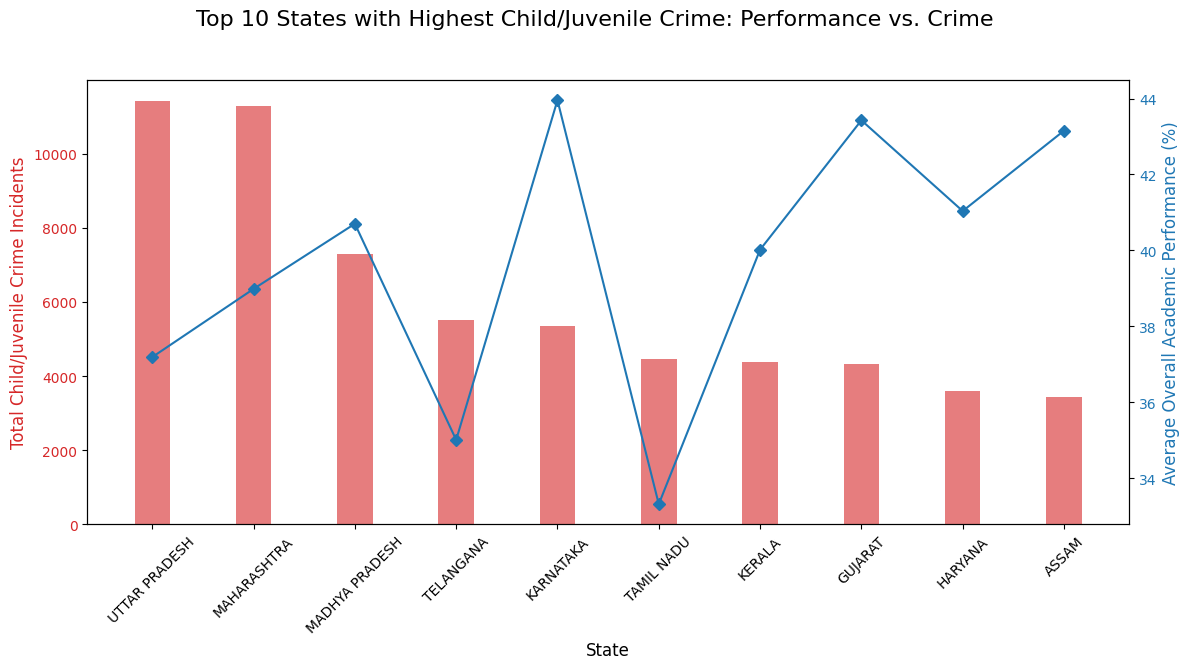

/tmp/ipython-input-3682418612.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Crime_Quartile', y='Overall_Performance', data=df_plot, palette='viridis', inner='quartile')


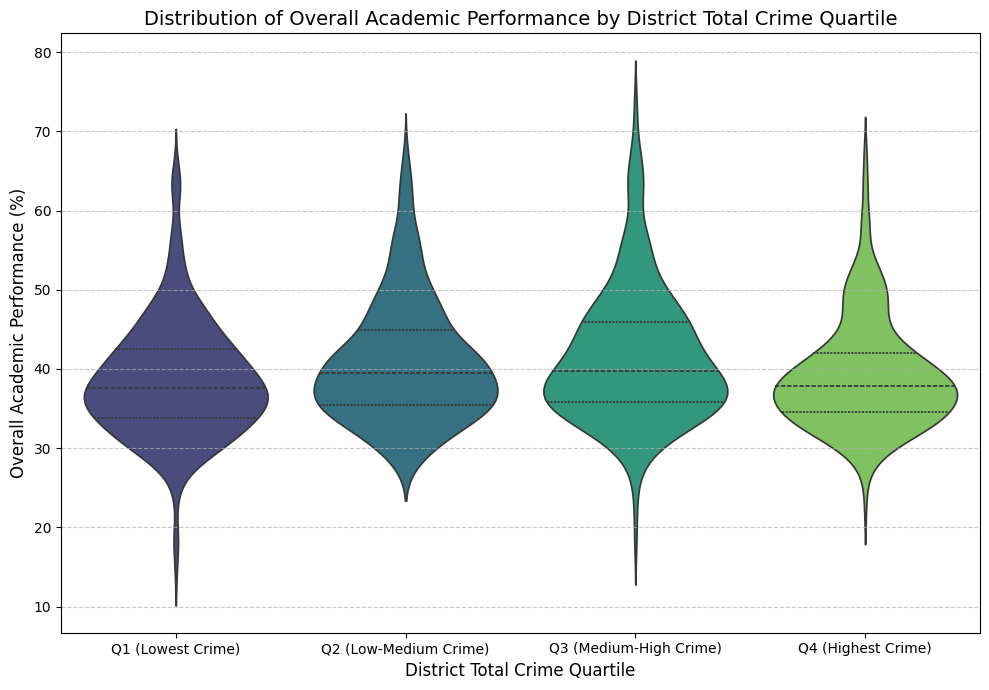

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading and Preparation (Self-Contained for Colab execution) ---

# Load datasets
try:
    df_nas = pd.read_csv("cleaned_dataset_NAS.csv")
    df_crime = pd.read_csv("districtwise-sll-crimes-2017-onwards.csv")
except FileNotFoundError:
    print("Error: Ensure both CSV files are uploaded to your Colab session.")
    # In a production script, you might exit here, but we continue for demonstration.

# Standardize column names and values for merging
df_crime = df_crime.rename(columns={
    'state_name': 'State',
    'district_name': 'District',
    'year': 'Year'
})

# Standardize case and strip whitespace
for df in [df_nas, df_crime]:
    df['State'] = df['State'].astype(str).str.upper().str.strip()
    df['District'] = df['District'].astype(str).str.upper().str.strip()

# Calculate Total Crime and specific crime metrics
crime_cols_to_sum = df_crime.select_dtypes(include=[np.float64]).columns.tolist()
df_crime['Total_Crime'] = df_crime[crime_cols_to_sum].sum(axis=1)

# Child and Juvenile Welfare Analysis Metrics
child_crime_cols = [
    'protection_of_children_from_sexual_offences',
    'juvenile_justice_care_and_protection_of_children',
    'prohibition_of_child_marriage',
    'child_labour_prohibition_regulation'
]
df_crime['Total_Child_Crimes'] = df_crime[child_crime_cols].sum(axis=1)

# Select necessary columns from crime data
crime_subset = df_crime[['State', 'District', 'Year', 'Total_Crime', 'Total_Child_Crimes']].copy()

# Merge the DataFrames
df_merged = pd.merge(df_nas, crime_subset, on=['State', 'District', 'Year'], how='inner')

# --- 1. Visualization: Child Welfare Analysis (Average Performance vs. Total Child Crimes) ---

# Aggregate by State: Calculate mean performance and total child crimes
df_child_agg = df_merged.groupby('State').agg({
    'Overall_Performance': 'mean',
    'Total_Child_Crimes': 'sum'
}).reset_index()

# Select top 10 states by highest Total Child Crimes for focus
df_child_agg = df_child_agg.sort_values(by='Total_Child_Crimes', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(12, 7))
width = 0.35

# Plot Total Child Crimes (Bar Plot)
color = 'tab:red'
ax1.set_xlabel('State', fontsize=12)
ax1.set_ylabel('Total Child/Juvenile Crime Incidents', color=color, fontsize=12)
ax1.bar(df_child_agg['State'], df_child_agg['Total_Child_Crimes'], width, color=color, alpha=0.6, label='Total Child Crimes')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Create a second axis for Overall Performance (Line Plot)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Overall Academic Performance (%)', color=color, fontsize=12)
ax2.plot(df_child_agg['State'], df_child_agg['Overall_Performance'], color=color, marker='D', label='Avg. Overall Performance')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Top 10 States with Highest Child/Juvenile Crime: Performance vs. Crime', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() # Display the plot

# --- 2. Visualization: Performance Distribution vs. Crime Quartiles (Socio-Educational Correlation) ---

# Prepare data by removing districts with zero crime or NaN to accurately calculate quartiles
df_plot = df_merged[df_merged['Total_Crime'] > 0].copy()
df_plot = df_plot.dropna(subset=['Overall_Performance', 'Total_Crime'])

# Create quartiles for Total Crime (dividing districts into 4 equal-sized groups based on crime rate)
df_plot['Crime_Quartile'] = pd.qcut(df_plot['Total_Crime'], q=4, labels=[
    'Q1 (Lowest Crime)', 'Q2 (Low-Medium Crime)', 'Q3 (Medium-High Crime)', 'Q4 (Highest Crime)'
])

plt.figure(figsize=(10, 7))
# A violin plot shows the density distribution, giving a richer view than a box plot.
sns.violinplot(x='Crime_Quartile', y='Overall_Performance', data=df_plot, palette='viridis', inner='quartile')
plt.title('Distribution of Overall Academic Performance by District Total Crime Quartile', fontsize=14)
plt.xlabel('District Total Crime Quartile', fontsize=12)
plt.ylabel('Overall Academic Performance (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() # Display the plot